# Cells for Google Colab

In [99]:
import os
runningFromColab = False
if 'CGROUP_MEMORY_EVENTS' in os.environ and 'colab' in os.environ['CGROUP_MEMORY_EVENTS']:
  runningFromColab = True

In [100]:
if runningFromColab:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
if runningFromColab:
  %cd /content/drive/MyDrive/WaterCrystal/final_project

/content/drive/MyDrive/WaterCrystal/final_project


In [102]:
if runningFromColab:
  !git clone https://github.com/OdyAsh/dl-water-crystals-synthesis-super-resolution.git

Cloning into 'dl-water-crystals-synthesis-super-resolution'...
remote: Enumerating objects: 5411, done.
remote: Counting objects: 100% (973/973), done.
remote: Compressing objects: 100% (923/923), done.
remote: Total 5411 (delta 50), reused 970 (delta 48), pack-reused 4438
Receiving objects: 100% (5411/5411), 820.18 MiB | 26.52 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Updating files: 100% (5271/5271), done.


In [103]:
if runningFromColab:
  %cd /content/drive/MyDrive/WaterCrystal/final_project/dl-water-crystals-synthesis-super-resolution

/content/drive/MyDrive/WaterCrystal/final_project/dl-water-crystals-synthesis-super-resolution


In [104]:
if runningFromColab:
  !git pull
  # if it DOES NOT say "Already up to date.", then you need to close this notebook file (i.e., the browser tab) and open it again for it to change 

Already up to date.


In [ ]:
if runningFromColab:
  !pip install huggingface-hub
  !pip install datasets
  !pip install diffusers[training]==0.11.1
  !pip install accelerate
  !pip install Augmentor
  # install Git-LFS to upload the model checkpoints
  !sudo apt -qq install git-lfs
  !git config --global credential.helper store

In [ ]:
# if runningFromColab:
#   try:
#     import condacolab
#     condacolab.install()
#   except:
#     !pip install -q condacolab
#     import condacolab
#     condacolab.install()
#     # now restart the kernel

In [ ]:
# if runningFromColab:
#   !conda env create -f environment.yml
#   # !conda update conda -y -q
#   # !source /usr/local/etc/profile.d/conda.sh
#   # !conda init 
#   # !conda install -n root _license -y -q
#   # !source activate myenv

In [ ]:
# if runningFromColab:
#   import sys
#   sys.path.insert(0, '/usr/local/bin/conda')

# Imports

In [ ]:
from huggingface_hub import notebook_login, login
from secretss import * # create secrets.py in same directory as this ipynb file, and add a line huggingface_token = "ASH_TOKEN_ASK_HIM"
# also, make sure secretss is double s, to avoid numpy conflicts. Source: https://stackoverflow.com/questions/73055157/what-does-importerror-cannot-import-name-randbits-mean#:~:text=Somehow%20anaconda3/Lib/secrets.py%20got%20overwritten
login(huggingface_token, add_to_git_credential=True) # ^^^^^^^^^^^^^^^^^^^^^

Token is valid.
Your token has been saved in your configured git credential helpers (manager-core,store).
Your token has been saved to C:\Users\ashra\.cache\huggingface\token
Login successful


# Configuring Training Variables in `config`

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
torch.cuda.empty_cache() # to free up gpu memory space if you've ran the model before (doesn't completly free memory though; you have to restart the kernel for that)

In [ ]:
data_dir = './dataset/Microparticle'

In [ ]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 1 # (adjustable)
    eval_batch_size = 1  # how many images to sample during evaluation, if 4 --> make_grid() should have 1 row and 4 columns, and so on (adjustable)
    num_epochs = 100
    gradient_accumulation_steps = 8 # performs optimization step when it accumulated gradients of 8 batches (so if train_batch_size = 4 for example, then optimization step is done after 8 * 4 = 32 images) (adjustable)
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "./hf_ldm_diffusion_microparticles_v1/"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [ ]:
# pulling model changes from huggingface

from pathlib import Path
from huggingface_hub import HfFolder, Repository, whoami
def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"
repo_name = get_full_repo_name(Path(config.output_dir).name)
repo = Repository(config.output_dir, clone_from=repo_name)
repo.git_pull()

# pushing model changes to huggingface (don't run if you don't want to push)
# repo.push_to_hub(commit_message=f"test", blocking=True)

d:\CS\projects\dl-water-crystals-synthesis-super-resolution\./hf_diffusion_model_all_sample_classes/ is already a clone of https://huggingface.co/OdyAsh/hf_diffusion_model_all_sample_classes. Make sure you pull the latest changes with `repo.git_pull()`.


Clean file unet/diffusion_pytorch_model.bin:   0%|          | 1.00k/434M [00:00<?, ?B/s]

# Importing Data

In [ ]:
from datasets import load_dataset

config.dataset_name = data_dir
dataset = load_dataset(config.dataset_name, split="train")

#  # equivalent to writing:
# config.dataset_name = "imagefolder"
# dataset = load_dataset(config.dataset_name, split="train", data_dir=data_dir)

# to get list of image paths (absolute paths from drive letter till filename):
# list(dataset.download_checksums.keys())

Resolving data files:   0%|          | 0/5029 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/ashra/.cache/huggingface/datasets/imagefolder/dataset-986c16cd08b1e2af/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


C:\Users\ashra\AppData\Local\Temp\ipykernel_8980\3278871621.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


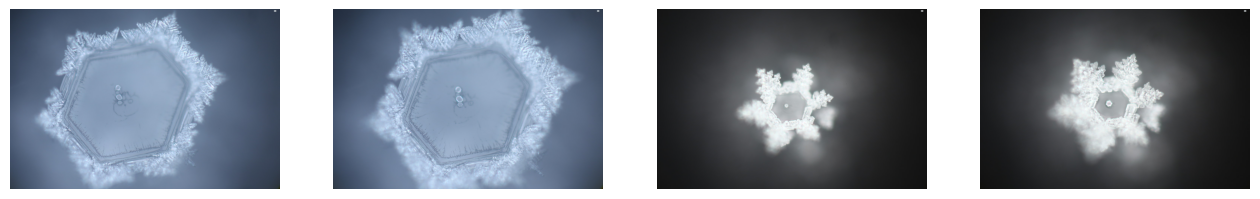

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

# Preparing Preprocessing & DataLoader Functions

In [ ]:
import Augmentor
aug_pipeline = Augmentor.Pipeline(data_dir)
aug_pipeline.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=5)
aug_pipeline.flip_left_right(probability=0.5)
aug_pipeline.zoom(probability=0.5, min_factor=1.1, max_factor=1.2) # assumes water crystal is always in center of image; always zooms in
aug_pipeline.flip_top_bottom(probability=0.5)
# aug_pipeline.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=2) # will not augment this way, as it will change structure of crystal

# Run for debugging purposes to see what the transformations could look like 
# By default these will be written to the disk in a directory named "output" which will be inside data_dir path
# aug_pipeline.sample(100) 

Initialised with 5029 image(s) found.
Output directory set to ./dataset/output.

In [ ]:
from torchvision import transforms

preprocess_pipeline = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        aug_pipeline.torch_transform(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
def transform(examples):
    images = [preprocess_pipeline(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform) 
# 
# Explanation note:
# set_transform(func) applies a custom formatting transform on-the-fly. This function replaces any previously specified format of the images.
# also, func is only applied when examples are accessed
# so if you don't run the line above, and print "dataset", you'll get:
#
# {'type': 'custom',
#  'format_kwargs': {},
#  'columns': ['image'],
#  'output_all_columns': False}
#
# and accessing an image, e.g., dataset[0], you'll get:
# 
# {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5472x3648>}
#
# However, running the set_transform() function will give you the following for dataset, dataset[0], and dataset[0]['images'].shape respectively:
#
# {'type': 'custom',
#  'format_kwargs': {'transform': <function __main__.transform(examples)>},
#  'columns': ['image'],
#  'output_all_columns': False}
#
# 
# {'images': tensor([[[-0.7098, -0.7176, -0.7098,  ..., -0.7255, -0.7333, -0.7255],
#           [-0.7098, -0.7020, -0.7020,  ..., -0.7255, -0.7176, -0.7176],
#           ...,
#           [-0.5686, -0.5608, -0.5529,  ..., -0.5137, -0.5294, -0.5294]]])}
#
#
# torch.Size([3, 128, 128])
# 
# noting that if you've written dataset[:2]['images'], it would've returned {'images': [tensor(...), tensor(...)]} 
# in other words, the key "images" is written once, and instead of returning tensor(), it will return list of tensors
# confusingly, if you index it like this: dataset[:1]['images'], it will return {'images': [tensor(...)]}, NOT {'images': tensor(...)}
#
# all of the logic said above applies also if you didn't run set_transform(), just replace 'images' with 'image', and 'tensor()' with <PIL> object
#

C:\Users\ashra\AppData\Local\Temp\ipykernel_8980\1866579057.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


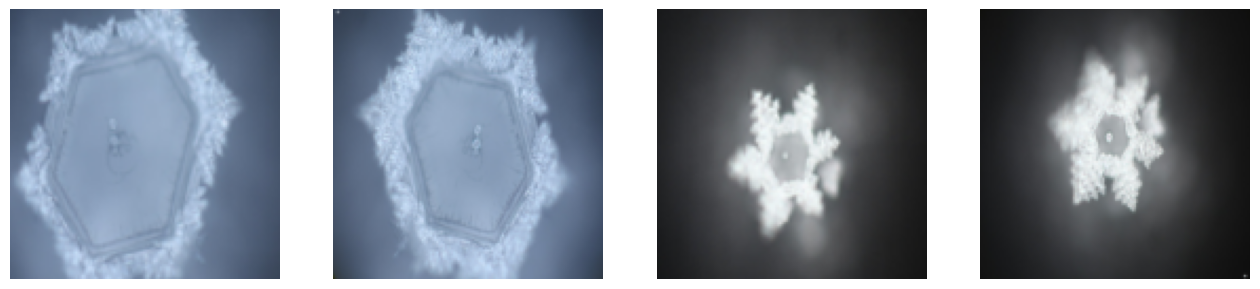

In [ ]:
# Let's see what they look like now
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    # image = preprocess_pipeline(image.convert("RGB"))
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [ ]:
# Setup the batch sampler class to take in a manually-specified number of image batches per epoch, instead of being automatically calculated as ceil(dataset_samples / batch_size)
import torch

class BatchSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, data_source, batch_size, num_batches, shuffle=True):
      self.data_source = data_source
      self.batch_size = batch_size
      self.num_batches = num_batches
      self.shuffle = shuffle

    def __iter__(self):
      # the __iter__ method returns the indices of the samples
      for i in range(self.num_batches):
        if self.shuffle:
            batch_indices = torch.randperm(len(self.data_source))[:self.batch_size].tolist() # generates a random permutation of integers from 0 to len(self.data_source) - 1.
        else:
            start_index = i * self.batch_size
            end_index = min(len(self.data_source), (i + 1) * self.batch_size) # doing min() to avoid IndexOutOfBounds error
            batch_indices = list(range(start_index, end_index))
        yield batch_indices

    def __len__(self):
      return self.num_batches


In [ ]:
# Now that all our images have the same size and are converted to tensors, we can create the dataloader we will use for training.
num_batches = len(dataset) // config.train_batch_size + (len(dataset) % config.train_batch_size != 0)
batch_sampler = BatchSampler(dataset, config.train_batch_size, 10, shuffle=True) # to do: change 8 to num_batches
train_dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=batch_sampler)

In [ ]:
from diffusers import UNet2DModel
# # edit: was this: "model =" instead of "unet ="
unet = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [ ]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", unet(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


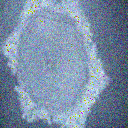

In [ ]:
import torch
from PIL import Image
from diffusers import DDIMScheduler

# edit: replaced noise_scheduler with ddim_noise_scheduler
ddim_noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = ddim_noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [ ]:
import torch.nn.functional as F

noise_pred = unet(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [ ]:
# edit: added this cell:
from diffusers import LDMPipeline, VQModel
vqm = VQModel(down_block_types=("DownEncoderBlock2D",), up_block_types=("UpDecoderBlock2D",), act_fn='silu', num_vq_embeddings=256, scaling_factor=0.18215)
model = LDMPipeline(vqvae=vqm, unet=unet, scheduler=ddim_noise_scheduler)

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup
from itertools import chain

# edit: changed model.parameters() to chain(model.vqvae.parameters(), model.unet.parameters())
optimizer = torch.optim.AdamW(chain(model.vqvae.parameters(), model.unet.parameters()), lr=config.learning_rate) # source for chain(): https://discuss.pytorch.org/t/how-to-optimize-multi-models-parameter-in-one-optimizer/3603/8#:~:text=You%20can%20use%20itertools.chain
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [ ]:
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images # to do: change rows, cols to 2, 2 if config.train_batch is 4, etc (adjustable)
    image_grid = make_grid(images, rows=1, cols=1)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# edit: added this for debugging:
torch.cuda.empty_cache()
for step, batch in enumerate(train_dataloader):
    print(batch['images'].shape)
    break
    # # to run on gpu:
    # batch['images'] = batch['images'][:2].to('cuda')
    # model.to('cuda')
    encoded_imgs = model.vqvae.encode(batch['images'])
    print(encoded_imgs.latents.shape)
    break

torch.Size([1, 3, 128, 128])


In [ ]:
from diffusers import DDIMPipeline
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
import gc
from tqdm.auto import tqdm
from pathlib import Path
import os


def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"


def train_loop(config, model, ddim_noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model.unet, model.vqvae, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model.unet, model.vqvae, optimizer, train_dataloader, lr_scheduler # edit: replaced model with model.unet, model.vqvae
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]

            # edit: added this part
            # Get the latent space (i.e., encoding) of the images
            
            embedded_clean_images = model.vqvae.encode(clean_images).latents
            
            # freeing gpu memory space
            torch.cuda.empty_cache()
            gc.collect()

            # Sample noise to add to the images
            # note: we're using clean_images.device (instead of embedded_clean_images.device), 
            # as the the former comes from the dataloader, whcich is responsible for setting the device to 'cpu' or 'cuda', etc
            noise = torch.randn(embedded_clean_images.shape).to(clean_images.device) 
            bs = embedded_clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, ddim_noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = ddim_noise_scheduler.add_noise(embedded_clean_images, noise, timesteps)
            
            # edit: replaced acc.acc(model) with acc.acc(model.vqvae), acc.acc(model.unet). 
            # source: https://github.com/huggingface/accelerate/issues/668#:~:text=This%20is%20pretty%20simple%20actually%2C%20just%20use%20%22with%20accelerator.accumulate(model1)%2C%20accelerator.accumulate(model2)%3A%20%22%20this%20is%20the%20mechanism%20of%20%22with%22%2C%20the%20following%20code%20will%20be%20in%20this%20two%20contexts%2C%20so%20just%20simply%20put%20them%20together%20with%20comma. 
            with accelerator.accumulate(model.vqvae), accelerator.accumulate(model.unet): 
                # Predict the noise residual
                # edit: was:
                # noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                noise_pred = model.unet(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(chain(model.vqvae.parameters(), model.unet.parameters()), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # freeing gpu memory space
        torch.cuda.empty_cache()
        gc.collect()

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            # # edit: was:
            # pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            with torch.no_grad(): # source: https://stackoverflow.com/questions/54374935/how-to-fix-this-strange-error-runtimeerror-cuda-error-out-of-memory#:~:text=1..%20When%20you%20only%20perform%20validation%20not%20training%2C%0Ayou%20don%27t%20need%20to%20calculate%20gradients%20for%20forward%20and%20backward%20phase.%0AIn%20that%20situation%2C%20your%20code%20can%20be%20located%20under
                pipeline = LDMPipeline(vqvae=accelerator.unwrap_model(model.vqvae), unet=accelerator.unwrap_model(model.unet), scheduler=ddim_noise_scheduler)
                if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                        # pipeline.to('cpu') # debugging: throws error: RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!
                        evaluate(config, epoch, pipeline)
                        # pipeline = pipeline.to('cuda') # debugging

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

In [ ]:
from accelerate import notebook_launcher

args = (config, model, ddim_noise_scheduler, optimizer, train_dataloader, lr_scheduler)

torch.cuda.empty_cache()

notebook_launcher(train_loop, args, num_processes=1)

torch.cuda.empty_cache()

# explanation note: when you see 0/batches_num to the right of the progress bar, "batches_num" here refers to len(train_dataloader), 
# which corresponds to the number of batches that the model will train on,
# and batches_num is calculated using --> ceil(dataset_samples / batch_size)
# such that:
#   dataset_samples --> number of images loaded into "dataset" variable --> len(dataset)
#   batch_size --> number of images trained simultaneously by the model --> config.train_batch_size

# however, you can manually pass batches_num that you want done per epoch using Dataloader()'s "batch_sampler" argument 

Launching training on one GPU.


d:\CS\projects\dl-water-crystals-synthesis-super-resolution\.venv\lib\site-packages\accelerate\accelerator.py:243: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│    4                                                                                             │
│    5 torch.cuda.empty_cache()                                                                    │
│    6                                                                                             │
│ ❱  7 notebook_launcher(train_loop, args, num_processes=1)                                        │
│    8                                                                                             │
│    9 torch.cuda.empty_cache()                                                                    │
│   10                                                                                             │
│                                                                                                  │
│ d:\CS\projects\dl-water-crystals-synthesis-super-resolution\.venv\lib\site-packages\accelerate\l │
│ aunchers.py:147 in notebook_launcher                                                             │
│                                                                                                  │
│   144 │   │   │   │   print("Launching training on one GPU.")                                    │
│   145 │   │   │   else:                                                                          │
│   146 │   │   │   │   print("Launching training on CPU.")                                        │
│ ❱ 147 │   │   │   function(*args)                                                                │
│   148                                                                                            │
│   149                                                                                            │
│   150 def debug_launcher(function, args=(), num_processes=2):                                    │
│                                                                                                  │
│ in train_loop:86                                                                                 │
│                                                                                                  │
│    83 │   │   │   │   # noise_pred = model(noisy_images, timesteps, return_dict=False)[0]        │
│    84 │   │   │   │   noise_pred = model.unet(noisy_images, timesteps, return_dict=False)[0]     │
│    85 │   │   │   │   loss = F.mse_loss(noise_pred, noise)                                       │
│ ❱  86 │   │   │   │   accelerator.backward(loss)                                                 │
│    87 │   │   │   │                                                                              │
│    88 │   │   │   │   accelerator.clip_grad_norm_(chain(model.vqvae.parameters(), model.unet.p   │
│    89 │   │   │   │   optimizer.step()                                                           │
│                                                                                                  │
│ d:\CS\projects\dl-water-crystals-synthesis-super-resolution\.venv\lib\site-packages\accelerate\a │
│ ccelerator.py:1634 in backward                                                                   │
│                                                                                                  │
│   1631 │   │   elif self.distributed_type == DistributedType.MEGATRON_LM:                        │
│   1632 │   │   │   return                                                                        │
│   1633 │   │   elif self.scaler is not None:                                                     │
│ ❱ 1634 │   │   │   self.scaler.scale(loss).backward(**kwargs)                                    │
│   1635 │   │   else:                                       

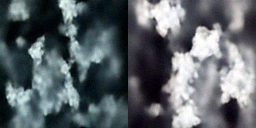

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])